In [1]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gp
import shapely
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import load_npz
import time
from scipy import stats
from itertools import combinations
import random
import copy
import math

sys.path.append("../../wave_cluster")
import wave_cluster as wc
sys.path.append("../../../disease")
import wavefinder
%load_ext autoreload
%autoreload 2

/share/pkg.7/python3/3.8.10/install/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.set_option('mode.chained_assignment', None)
# json file with geographic info for each state -- required for graphing
#country_map = gp.read_file("../../data/country_shp/World_Countries_Generalized.shp")
country_map = gp.read_file("../../data/visualization/world-administrative-boundaries/world-administrative-boundaries.shp")

In [3]:
country_map.columns

Index(['iso3', 'status', 'color_code', 'name', 'continent', 'region',
       'iso_3166_1_', 'french_shor', 'geometry'],
      dtype='object')

<AxesSubplot:>

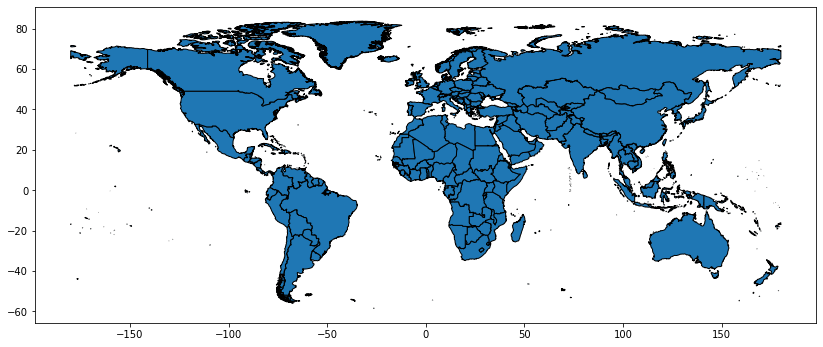

In [4]:
fig,ax = plt.subplots(figsize = (14,8))
country_map.plot(ax = ax, edgecolor="black")

### Import Data

In [5]:
# Import data
index = pd.read_csv("../../data/index.csv", index_col = 0)
demographics = pd.read_csv("../../data/demographics.csv", index_col = 0)

data = pd.read_csv("../../data/country_daily.csv", index_col = 0)
dr = ['CW', 'GG', 'IM', 'JE', 'SH', 'SX', 'WF', 'XK']
data = data.drop(dr, axis = 1)
data = data.iloc[32:,:]
population = demographics.loc[data.columns,"population"]

data = data.fillna(0)
norm_data = data.apply(lambda x: x/population[x.name])
data = norm_data * 100000 # cases per 1000
original = data.copy(deep = True)

# Smoothing!
front = 7
back = 7
smooth_data = wc.window_average(data.to_numpy(), front = front, back = back)
smooth_data = wc.window_average(smooth_data, front = front, back = back)
smooth_data = wc.window_average(smooth_data, front = front, back = back)
smoothed_index = data.index[3*front:-3*back]
data = pd.DataFrame(smooth_data, index = smoothed_index, columns = data.columns)
data[data < 0] = 0

data.index = pd.to_datetime(data.index)

EU = ['AD', 'AL', 'AM','AT','AZ','BA', 'BE', 'BG','BY', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR',
     'DE', 'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL', 
     'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE', 'GB', 'GE', 'IS', 'KZ', 'LI', 'MD', 'MC', 'ME',
     'MK', 'NO', 'RU', 'SM', 'RS', 'CH', 'TR', 'UA']

locations = np.sort(EU)

data = data.loc[:,locations]
data = data.drop(['AM','MK', 'ME'], axis = 1)
locations = data.columns

In [6]:
geo = pd.read_csv("../../data/geography.csv", index_col = 0)
country_centers_dict = {i: np.array(geo.loc[i, ['latitude', 'longitude']]).flatten() for i in data.columns}
# Some locations were un-reported so I use coordinates reported by wikidata
#country_centers_dict['AM'] = np.array([40.383333, 44.95])
#country_centers_dict['MK'] = np.array([41.65, 21.716667])
country_centers_dict['GE'] = np.array([42, 44])


'''
country_pairs = list(combinations(data.columns, 2))
country_pairs += [(i,i) for i in data.columns]
weighted_miles = []

for p in country_pairs:
    # geographic distance
    x_loc = country_centers_dict[p[0]]
    y_loc = country_centers_dict[p[1]]
    dist = wc.haversine(x_loc, y_loc)
    weighted_miles.append((p[0], p[1], dist))
    

G_miles = nx.Graph()
G_miles.add_nodes_from(data.columns)
G_miles.add_weighted_edges_from(weighted_miles)
'''

# containment_health
containment_health = pd.read_csv('../../data/country_containment_health.csv', index_col = 0)


unimodal_cuts = pd.read_csv("../../batch3/country/data/unimodal_cuts.csv", index_col = 0)
unimodal_cuts = unimodal_cuts.iloc[::2,:]
unimodal_cuts = unimodal_cuts.loc[:, locations]
D_uni = load_npz('../../batch3/country/data/unimodal_pairwise.npz')
wpool_uni = wc.wave_pool(data, unimodal_cuts)

sir_cuts = pd.read_csv('../../batch3/country/data/sir_cuts.csv', index_col = 0)
D_sir = load_npz('../../batch3/country/data/sir_pairwise.npz')
wpool_sir = wc.wave_pool(data, sir_cuts)

wavefinder_cuts = pd.read_csv("../../batch3/country/data/wav_cuts.csv", index_col = 0)
wavefinder_cuts = wavefinder_cuts.loc[:, locations]
D_wav = load_npz('../../batch3/country/data/wav_pairwise.npz')
wpool_wav = wc.wave_pool(data, wavefinder_cuts[data.columns])


def miles_dist(loc1, loc2):
    loc1 = loc1[:loc1.rfind('_')]
    loc2 = loc2[:loc2.rfind('_')]
    x_loc = country_centers_dict[loc1]
    y_loc = country_centers_dict[loc2]
    return wc.haversine(x_loc, y_loc)


D_uni_miles = wc.pairwise_from_pool(wpool_uni, miles_dist)
D_sir_miles = wc.pairwise_from_pool(wpool_wav, miles_dist)
D_wav_miles = wc.pairwise_from_pool(wpool_sir, miles_dist)


D_uni_health = load_npz('../../batch3/country/data/unimodal_pairwise_health.npz')
D_sir_health = load_npz('../../batch3/country/data/sir_pairwise_health.npz')
D_wav_health = load_npz('../../batch3/country/data/wav_pairwise_health.npz')

### Visualization

In [7]:
map_included = []
for i in range(len(data.columns)):
    if len(country_map.loc[country_map['iso_3166_1_'] == data.columns[i]]) > 0:
        map_included.append(data.columns[i])
    else:
        print(data.columns[i])
        
#data = data.loc[:,map_included]

In [8]:
data_included = []
for row in range(len(country_map)):
    if country_map.iloc[row,:]['iso_3166_1_'] in data.columns:
        data_included.append(row)

country_map = country_map.iloc[data_included,:]
country_map.index = range(len(data_included))

(30.0, 75.0)

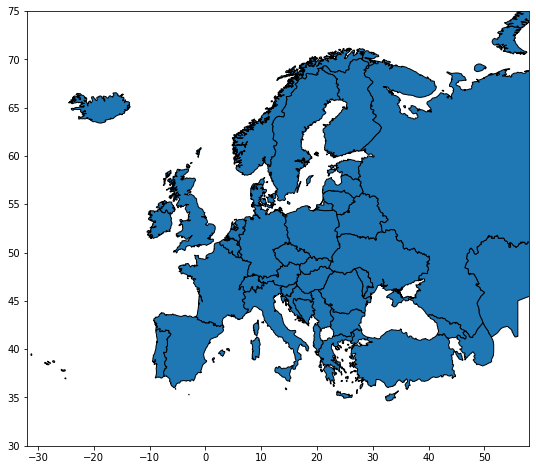

In [9]:
fig,ax = plt.subplots(figsize = (14,8))
country_map.plot(ax = ax, edgecolor="black")
ax.set_xlim(-32,58)
ax.set_ylim(30,75)

In [10]:
data.columns

Index(['AD', 'AL', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BY', 'CH', 'CY', 'CZ', 'DE',
       'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IE', 'IS',
       'IT', 'KZ', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 'MT', 'NL', 'NO', 'PL',
       'PT', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK', 'SM', 'TR', 'UA'],
      dtype='object')

## Segmentation

In [13]:
location = 'ES'
sir_segment = sir_cuts.loc[:,location].to_numpy()
sir_segment = sir_segment[~np.isnan(sir_segment)]
unimodal_segment = unimodal_cuts.loc[:,location].to_numpy()
unimodal_segment = unimodal_segment[~np.isnan(unimodal_segment)]
wav_segment = wavefinder_cuts.loc[:,location].to_numpy()
wav_segment = wav_segment[~np.isnan(wav_segment)]

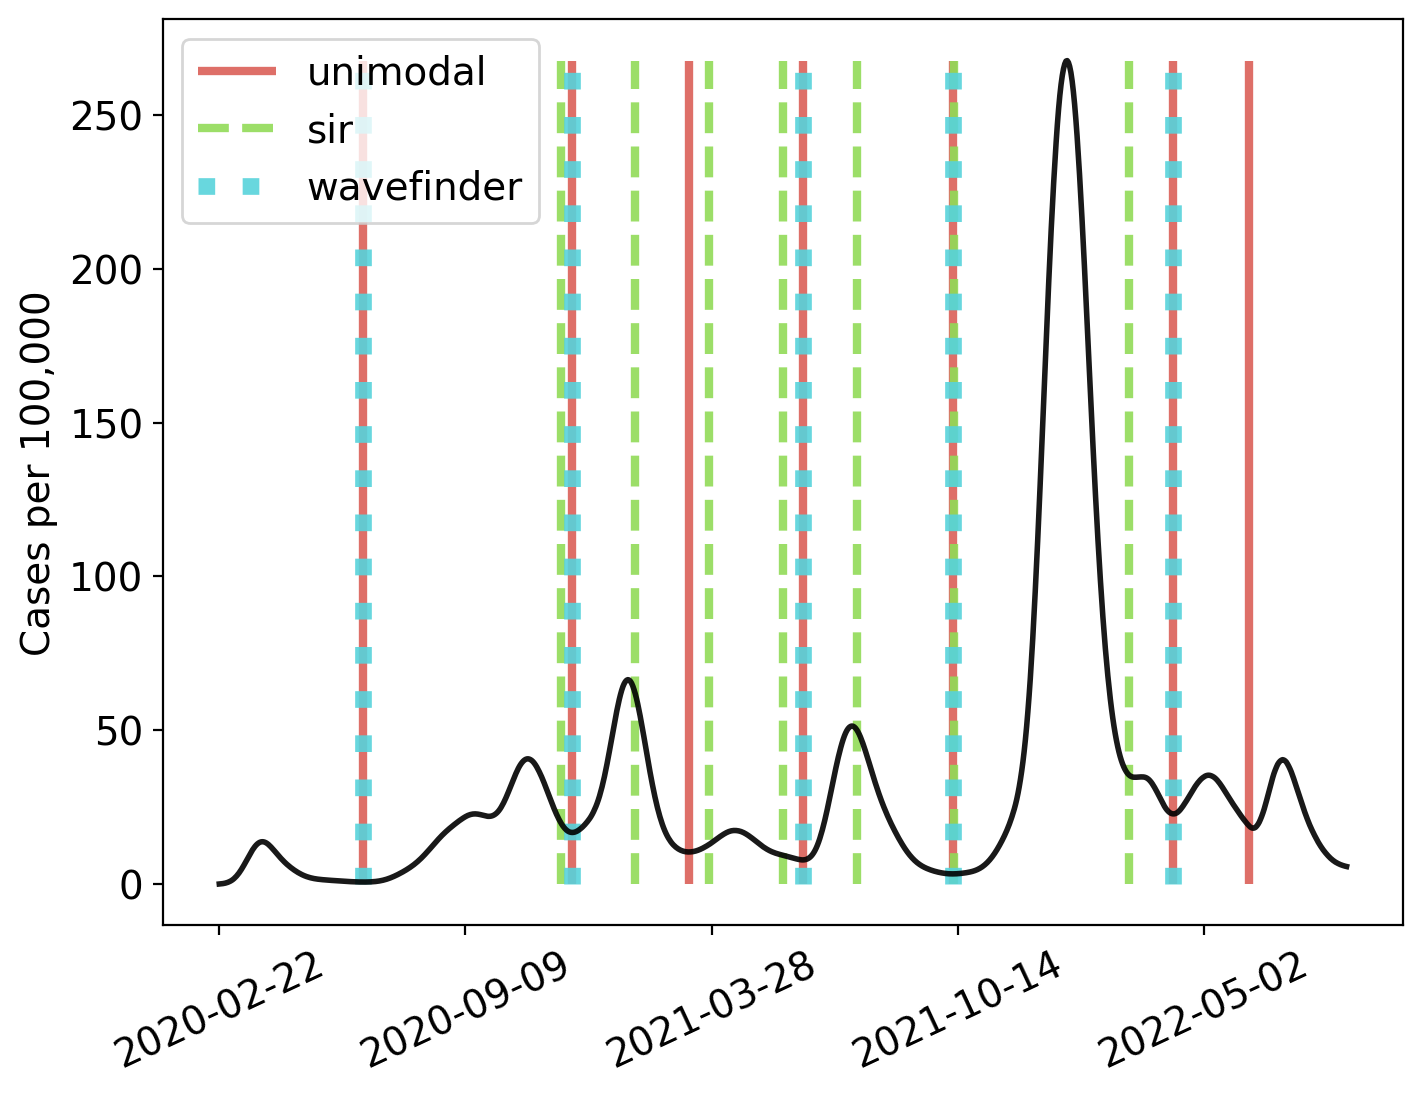

In [14]:
fig,ax = plt.subplots(1,1,figsize = (8,6), dpi = 200)
ax.plot(data.loc[:,location].to_numpy(), color = 'k', alpha = 0.9, linewidth = 2)
pal = sns.color_palette("hls", 8)
plt.rcParams.update({'font.size': 14})


for c in range(1,len(unimodal_segment)-1):
    if c == 1:
        ax.vlines(unimodal_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[0], linestyle = '-', alpha = 0.9, label = 'unimodal', linewidth = 3)
    else:
        ax.vlines(unimodal_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[0], linestyle = '-', alpha = 0.9, linewidth = 3)
        
        
for c in range(1,len(sir_segment)-1):
    if c == 1:
        ax.vlines(sir_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[2], linestyle = '--', alpha = 0.9, label = 'sir', linewidth = 3)
    else:
        ax.vlines(sir_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[2], linestyle = '--', alpha = 0.9, linewidth = 3)
        
        

for c in range(1,len(wav_segment)-1):
    if c == 1:
        ax.vlines(wav_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[4], linestyle = 'dotted', alpha = 0.9, label = 'wavefinder', linewidth = 6)
    else:
        ax.vlines(wav_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[4], linestyle = 'dotted', alpha = 0.9, linewidth = 6)
        
plt.xticks(ticks=[0, 200, 400, 600, 800], labels=[str(data.index[0])[:10], str(data.index[200])[:10], str(data.index[400])[:10], 
                                                  str(data.index[600])[:10], str(data.index[800])[:10]])

plt.ylabel('Cases per 100,000')
plt.xticks(rotation=25) 
plt.legend()

In [15]:
disagreements1 = wc.compute_disagreements(data.columns, range(data.shape[0]), sir_cuts, unimodal_cuts)
disagreements2 = wc.compute_disagreements(data.columns, range(data.shape[0]), wavefinder_cuts, unimodal_cuts)
disagreements3 = wc.compute_disagreements(data.columns, range(data.shape[0]), sir_cuts, wavefinder_cuts)

In [16]:
# random segments:
def get_random_segments():
    max_segments = 10
    segment_size = 60

    rand_cuts = np.zeros((max_segments + 1, len(locations)))

    for l in range(len(locations)):
        loc = locations[l]
        vec = data.loc[:,loc].to_numpy()

        ucuts = unimodal_cuts.loc[:,loc].to_numpy()
        chosen_segs = int((len(ucuts[~np.isnan(ucuts)]) - 1))
        
        rand_seg = wc.random_segment(vec, chosen_segs, segment_size)
        rcuts = rand_seg.generate()

        rand_cuts[:len(rcuts),l] = rcuts
        

    rand_cuts = pd.DataFrame(rand_cuts, columns = locations)
    rand_cuts.replace(0, np.nan, inplace=True)
    rand_cuts.iloc[0,:] = np.zeros(rand_cuts.shape[1])
    return rand_cuts

In [17]:
# average disagreements for rand cuts
samples = 10000
disagreements4 = np.zeros((samples, len(locations)))

for s in range(samples):
    rand_cuts = get_random_segments()
    disagreements4[s,:] = wc.compute_disagreements(data.columns, range(data.shape[0]), rand_cuts, unimodal_cuts)
    
avg_disagreements = np.mean(disagreements4, axis = 0)

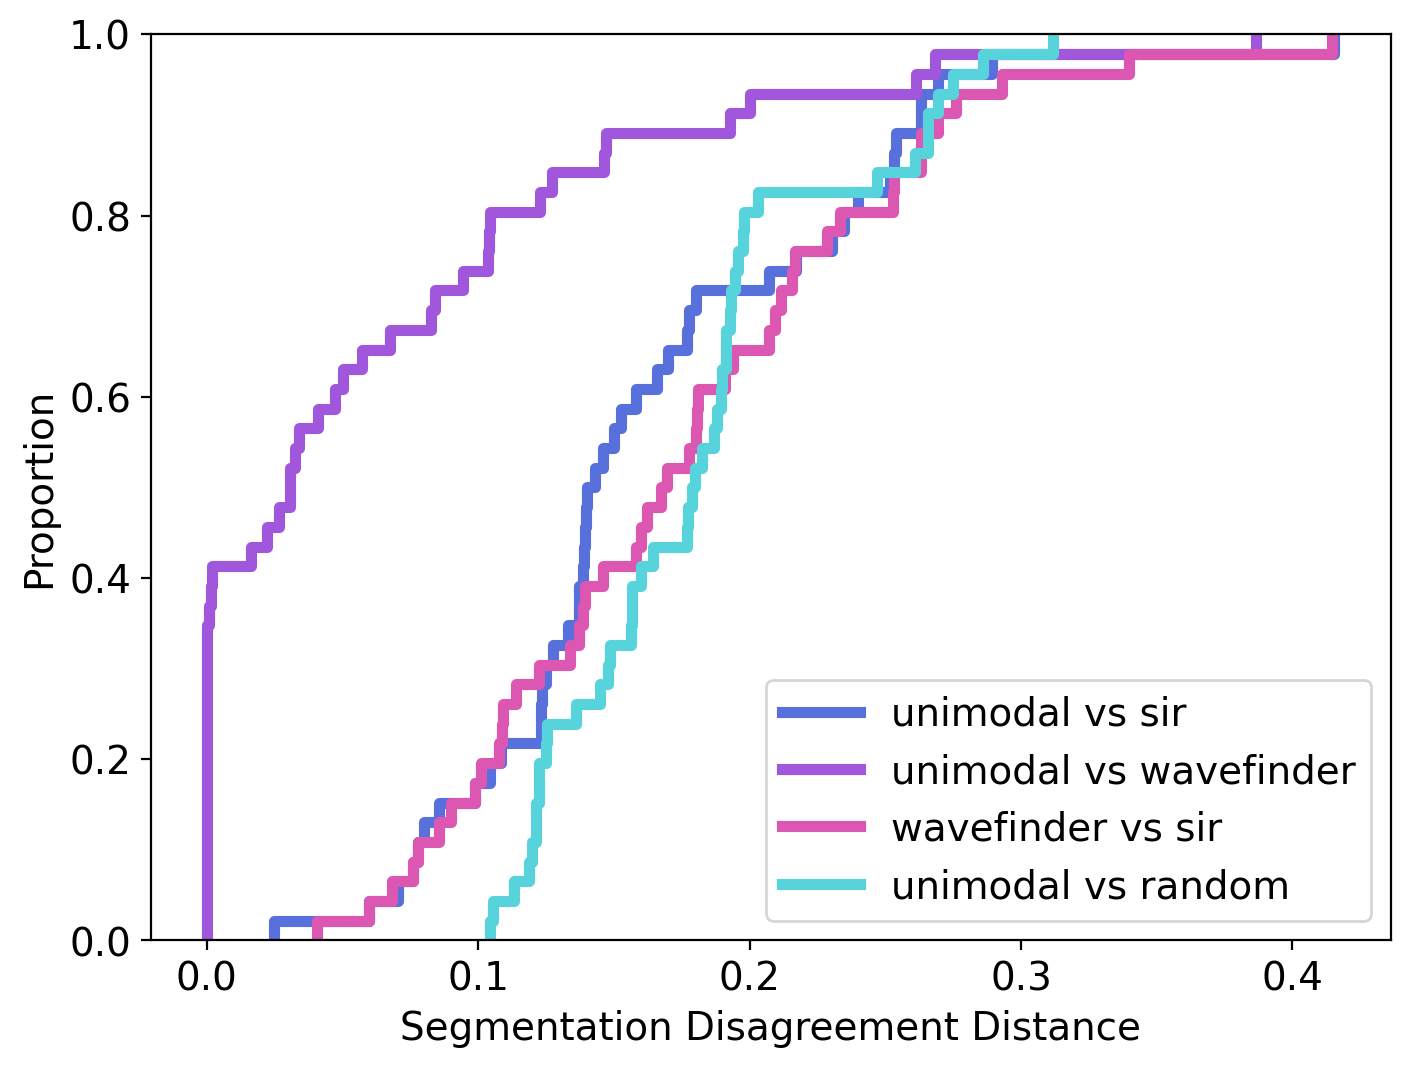

In [18]:
fig,ax = plt.subplots(figsize = (8,6), dpi = 200)
pal = sns.color_palette("hls", 8)
plt.rcParams.update({'font.size': 14})

sns.ecdfplot(disagreements1, color = pal[5], linewidth = 4, stat = 'proportion', label = 'unimodal vs sir')
sns.ecdfplot(disagreements2, color = pal[6], linewidth = 4, stat = 'proportion', label = 'unimodal vs wavefinder')
sns.ecdfplot(disagreements3, color = pal[7], linewidth = 4, stat = 'proportion',linestyle='-', label = 'wavefinder vs sir')
sns.ecdfplot(avg_disagreements, color = pal[4], linewidth = 4, stat = 'proportion',linestyle='-', label = 'unimodal vs random')

ax.set_xlabel('Segmentation Disagreement Distance')
plt.legend()
#plt.xlim(0,1)

### Choosing Parameters

In [20]:
D_uni = load_npz('../../batch3/data/country/europe_unimodal_pairwise.npz')
wpool_uni = wc.wave_pool(data, unimodal_cuts[data.columns])

In [22]:
# Next I've pre-computed some stats on each of our clustering methods at different parameter values
# These should give us an idea for which parameter values we might be interested in
param_info = pd.read_csv('../../batch3/country/data/parameter_info.csv', index_col = 0)
param_info.overlap = np.round(param_info.overlap, 2)

# These are all of the parameter values being tested (all combinations possible)
percent_try = np.round(np.linspace(0.3,1,15),2)
threshold_try = np.round(np.linspace(0,0.4,21),2)

In [44]:
# Choose a specific clustering method to analyze its results
method = 'uni'
method_param_info = param_info.loc[param_info.method == method]
pcombs = method_param_info.loc[:,['overlap', 'threshold']].value_counts().index
method_param_averages = []
samps = method_param_info['sample'].value_counts().index

for p in pcombs:
    ploc = method_param_info[(method_param_info['overlap'] == p[0]) & (method_param_info['threshold'] == p[1])]
    
    if len(samps) == 0:
        #ploc = ploc.loc[ploc.cluster_size >= 2]
        method_param_averages += [ploc.mean().to_list()[1:]]
    else:
        savg = []
        for s in samps:
            psloc = ploc[ploc['sample'] == s]
            psloc = psloc.loc[psloc.cluster_size >= 2]
            savg += [psloc.mean().to_list()[1:]]

        method_param_averages += [list(np.mean(savg, axis = 0))]
        
    
method_param_averages = pd.DataFrame(method_param_averages, columns = method_param_info.columns[2:])
method_param_averages = method_param_averages.drop(['cluster'], axis = 1)
method_param_averages.overlap = np.round(method_param_averages.overlap, 2)
method_param_averages.threshold = np.round(method_param_averages.threshold, 2)

In [45]:
var = 'silhouette_score'
param = method_param_averages
param_matrix = np.zeros((len(threshold_try), len(percent_try)))
for t in range(len(threshold_try)):
    thrsh = param.loc[param.threshold == threshold_try[t]]
    for p in range(len(percent_try)):
        try:
            prcnt = thrsh.loc[thrsh.overlap == percent_try[p]]
            param_matrix[t,p] = prcnt[var]
        except:
            print((p,t))

Text(0.5, 1.0, 'silhouette score')

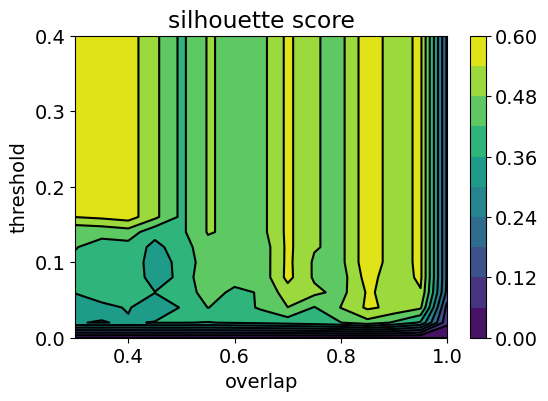

In [46]:
fig, ax = plt.subplots(dpi = 100)
cs = ax.contourf(percent_try, threshold_try, param_matrix, levels = 10)
ax.contour(cs, colors='k')
cbar = fig.colorbar(cs)
ax.set_xlabel('overlap')
ax.set_ylabel('threshold')
ax.set_title('silhouette score')

In [47]:
param.iloc[param.silhouette_score.idxmax(),:]

overlap               3.000000e-01
threshold             3.200000e-01
cluster_size          1.631250e+01
cost                  7.126374e-02
silhouette_score      5.985747e-01
total_points          2.636375e+03
explained_variance    1.192287e+07
diameter_miles        1.148771e+03
containment_health    1.056603e+01
avg_infections        5.358503e+01
Name: 304, dtype: float64

In [52]:
param.loc[param.overlap == 0.8]

,overlap,threshold,cluster_size,cost,silhouette_score,total_points,explained_variance,diameter_miles,containment_health,avg_infections
8,0.8,0.00,1.000000,0.000000,0.000000,161.616858,7.309040e+05,0.000000,0.000000,42.598689
58,0.8,0.02,2.351351,0.007164,0.418712,380.018018,1.718612e+06,562.410859,5.306436,41.835250
89,0.8,0.04,3.389610,0.014466,0.481879,547.818182,2.477480e+06,691.897109,6.046235,39.119868
108,0.8,0.06,3.728571,0.017145,0.460790,602.600000,2.725228e+06,734.839357,6.411000,38.808989
109,0.8,0.08,3.895522,0.017946,0.452492,629.582090,2.847253e+06,741.424709,6.472631,39.108710
110,0.8,0.38,3.954545,0.019184,0.463804,639.121212,2.890393e+06,742.725709,6.581406,39.333346
111,0.8,0.20,3.954545,0.019184,0.463804,639.121212,2.890393e+06,742.725709,6.581406,39.333346
112,0.8,0.40,3.954545,0.019184,0.463804,639.121212,2.890393e+06,742.725709,6.581406,39.333346
113,0.8,0.10,3.954545,0.019184,0.463804,639.121212,2.890393e+06,742.725709,6.581406,39.333346
114,0.8,0.12,3.954545,0.019184,0.463804,639.121212,2.890393e+06,742.725709,6.581406,39.333346


In [ ]:
# Some good parameter values (overlap, threhsold) found with silhouette score:
# Unimodal: (0.85, 0.2)
# SIR: (0.85, 0.16)
# WAV: (0.4, 0.12)

### Clique Clustering

In [10]:
# Specify setting for clustering
wpool = wpool_uni
D = D_uni

overlap = 0.85
threshold = 0.2
edge_list = wc.overlap_graph(overlap, wpool)
cliquer = wc.clique_cluster(D, edge_list, linkage = 'complete', threshold = threshold)
cliquer.cluster(1)

# Pre-computed Clusters
C = cliquer.C
'''
clusters = pd.read_csv('../../batch3/data/country/clusters.csv', index_col = 0)

C = []
for i in range(len(clusters)):
    cluster_loc = clusters.iloc[i,:].to_list()
    c = [i for i in cluster_loc if not np.isnan(i)]    
    c = [int(i) for i in c]
    C.append(c)
    
cliquer.C = C


cluster_analysis = wc.cluster_analyze(cliquer, segment_pool = wpool)
clustering = cluster_analysis.clustering
labels = cluster_analysis.labels

# Other collected data
cluster_data = pd.read_csv('../../batch3/data/country/uni_analysis.csv', index_col = 0)
cluster_data_nons = cluster_data.loc[cluster_data.cluster_size > 1]
'''

cluster_analysis = wc.cluster_analyze(cliquer, segment_pool = wpool)
clustering = cluster_analysis.clustering
labels = cluster_analysis.labels

dist_matrices = [D_uni_miles, D_uni_health]
cluster_data = wc.auxiliary_info(cliquer, wpool, dist_matrices = dist_matrices, health_index = containment_health, infection_data = data)
cluster_data = pd.DataFrame(cluster_data, columns = ['cluster','cluster_size', 'cost', 'total_points','explained_variance',
                                                     'silhouette', 'geo_silhouette','health_silhouette', 'containment_health', 'avg_infections'])
cluster_data_nons = cluster_data.loc[cluster_data.cluster_size > 1]

In [11]:
# Record every wave
cluster_waves = {}
for clust in range(len(C)):
    time_overlap_min = -1
    time_overlap_max = np.inf
    data_names = []
    for l in C[clust]:
        lname = wpool.key_list[l]
        data_names.append(lname[:-2])
        ltimes = wpool.times[lname]
        if ltimes[0] > time_overlap_min:
            time_overlap_min = ltimes[0]
        if ltimes[1] < time_overlap_max:
            time_overlap_max = ltimes[1]
            
        
    cluster_wave_data = data.loc[:, data_names]
    cluster_wave_data.iloc[:time_overlap_min,:] = np.nan
    cluster_wave_data.iloc[time_overlap_max:,:] = np.nan
    #cluster_wave_data = cluster_wave_data.iloc[time_overlap_min:time_overlap_max,:]
    cluster_waves[clust] = cluster_wave_data

In [12]:
cluster_data_nons['point_cost'] = cluster_data_nons['total_points']/cluster_data_nons['cost']
cluster_data_nons['variance_cost'] = cluster_data_nons['explained_variance']/cluster_data_nons['cost']

In [13]:
# Here I greedily select the clusters that cover the most data points and will plot how the total 
# percent of data points covered changes as I select more and more clusters
point_cdf = cluster_data.sort_values(by = 'total_points', ascending = False).total_points.to_numpy()
point_cdf = point_cdf / (data.shape[0]*data.shape[1])

# Likewise I'm also finding the clusters which explain the most amount of variance in the data and will 
# plot how the percent of explained variance changes
var_cdf = cluster_data.sort_values(by = 'explained_variance', ascending = False).explained_variance.to_numpy()
X = data.to_numpy()
X = X - np.mean(X, axis = 0)
#X = X - np.mean(X)
X = X ** 2
var_cdf = var_cdf / np.sum(X)

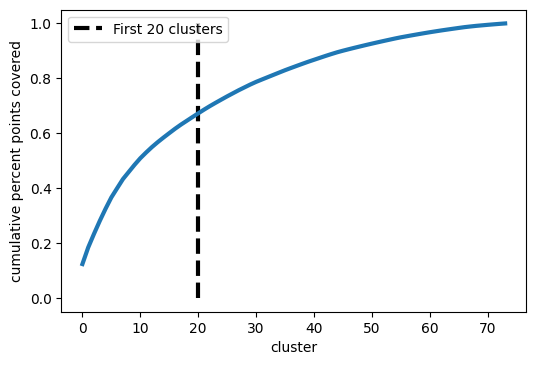

In [14]:
fig,ax = plt.subplots(dpi = 100)
ax.plot(np.cumsum(point_cdf), linewidth = 3)
ax.set_xlabel('cluster')
ax.set_ylabel('cumulative percent points covered')
ax.vlines(x = 20, ymin = 0, ymax = np.max(np.cumsum(point_cdf)), linestyle = '--', color = 'k', linewidth = 3, label = 'First 20 clusters')
plt.legend()

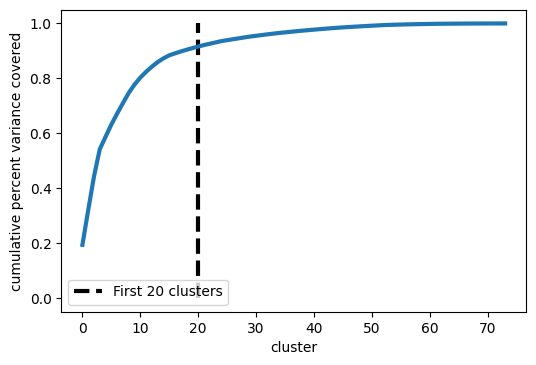

In [15]:
fig,ax = plt.subplots(dpi = 100)
ax.plot(np.cumsum(var_cdf), linewidth = 3)
ax.set_xlabel('cluster')
ax.set_ylabel('cumulative percent variance covered')
ax.vlines(x = 20, ymin = 0, ymax = np.max(np.cumsum(var_cdf)), linestyle = '--', color = 'k', linewidth = 3, label = 'First 20 clusters')
plt.legend()

In [16]:
cluster_data_nons.sort_values(by = 'point_cost', ascending = False).head(5)

,cluster,cluster_size,cost,total_points,explained_variance,silhouette,geo_silhouette,health_silhouette,containment_health,avg_infections,point_cost,variance_cost
40,40,15,0.017339,5215,5.815900e+06,1.000000,1.000000,1.000000,46.029062,11.923779,300772.265879,3.354288e+08
22,22,3,0.002378,471,2.106380e+05,0.937646,0.587432,0.104605,41.242521,17.822398,198100.368735,8.859335e+07
33,33,6,0.010382,1742,2.104892e+06,1.000000,1.000000,1.000000,44.923167,9.951059,167784.725463,2.027375e+08
45,45,5,0.020736,2551,4.814052e+06,0.651454,0.597983,0.161001,46.491065,17.375364,123025.221064,2.321638e+08
25,25,2,0.004221,513,3.557819e+06,1.000000,1.000000,1.000000,52.897826,60.394989,121542.849852,8.429385e+08


In [17]:
cluster_select = 40
indices = np.where(labels == cluster_select)[0]
locs = [wpool.key_list[i][:-2] for i in indices]
locc = [wpool.key_list[i] for i in indices]

n_clusters = int(np.max(labels)) + 1
smapn = sns.color_palette("tab20b")[::-1]
cmapn = LinearSegmentedColormap.from_list('mymapn', smapn, N=n_clusters)
smapt = [(1,1,1), cmapn(cluster_select)]
cmapt = LinearSegmentedColormap.from_list('mymapt', smapt, N=2)

(30.0, 75.0)

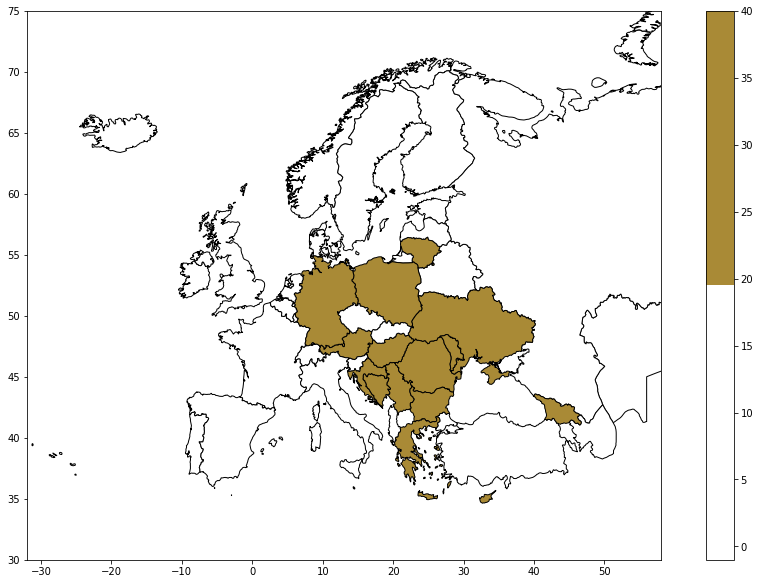

In [18]:
val_col = np.zeros(len(country_map)) - 1
for l in locs:
    c_loc = country_map.loc[country_map['iso_3166_1_'] == l]
    ind = c_loc.index[0]
    val_col[ind] = cluster_select

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (14,8))
country_map['val'] = val_col        
country_map.plot(column='val',legend=True, ax = ax, cmap = cmapt, edgecolor = 'black')
ax.set_xlim(-32,58)
ax.set_ylim(30,75)

(array([18322., 18383., 18444., 18506., 18567., 18628., 18687.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

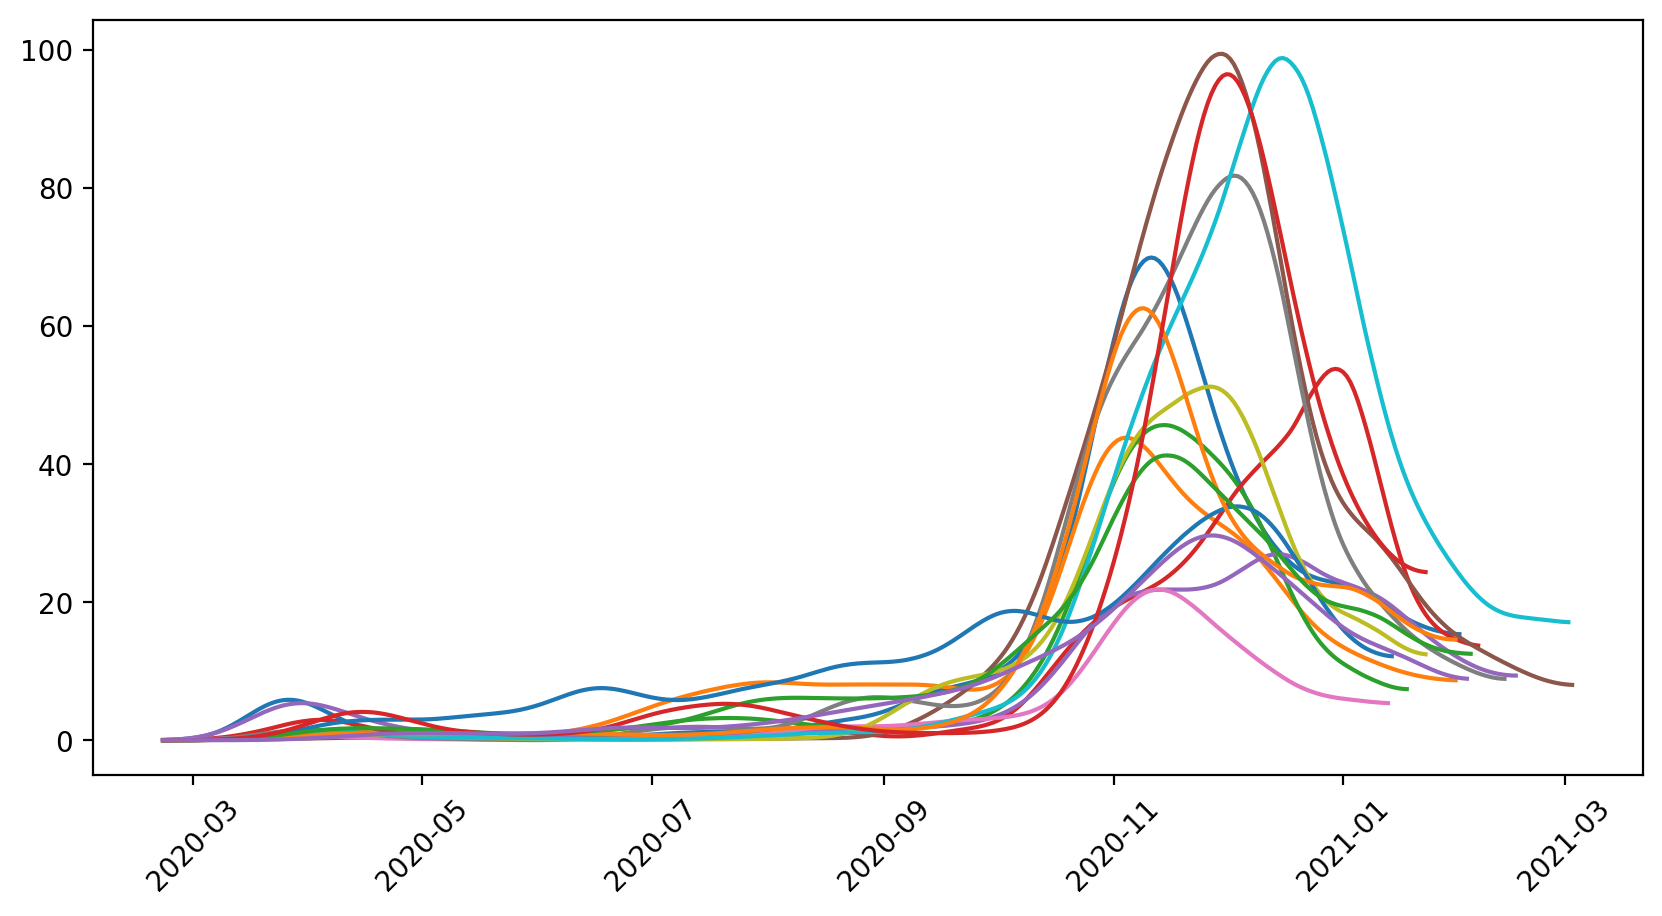

In [19]:
fig, ax = plt.subplots(figsize=(10,5), dpi = 200)

dlocc = [i[:-2] for i in locc]

for i in range(len(indices)):
    wname = wpool.key_list[indices[i]]
    seg_times = wpool.times[wname]
    t1 = int(seg_times[0])
    t2 = int(seg_times[1])
    ax.plot(data.loc[:,wname[:-2]][t1:t2], label = wname)

    
plt.xticks(rotation=45)
#plt.legend()

### Clusters By time

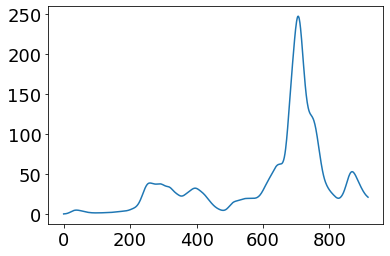

In [113]:
plt.plot(np.mean(data,axis = 1).to_numpy())

In [20]:
# Given a time stamp, find all segments which contain it
def get_segments(time, time_frame):
    time_segments = []
    for segment in range(len(wpool.key_list)):
        wname = wpool.key_list[segment]
        wtimes = wpool.times[wname]
        if time >= wtimes[0] and time < wtimes[1]:
            if wtimes[0] >= time_frame[0] and wtimes[1] <= time_frame[1]:
                time_segments.append(segment)
    return time_segments


# Find all clusters which are fully represented by a list of segments,
# I.e. only record a cluster as present if all of its segments are in the input list
def segment_clusters(segments):
    time_segment_clusters = []
    for c in range(len(cliquer.C)):
        cluster = set(cliquer.C[c])
        covered = set()
        for seg in segments:
            if seg in cluster:
                covered = covered.union({seg})
                
        if cluster == covered:
            time_segment_clusters.append(c)
                    
    return time_segment_clusters

In [174]:
# select a time and plot the clusters covered
# 0: (0, 200)
# 250: (0, 500)
# 550: (400, 700)
# 700: (500, 900)
# 850: (700, 1000)

time = 850
time_frame = (700,1000)
time_segments = get_segments(time, time_frame)
time_segment_clusters = segment_clusters(time_segments)

locs = [wpool.key_list[i][:-2] for i in time_segments]
loccs = [wpool.key_list[i] for i in time_segments]

sequential_cmap = plt.cm.tab20

unique_clusters = np.sort(list(set(time_segment_clusters)))
colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(20)]
custom_cmap = ListedColormap(colors)

color_indices = np.round(np.linspace(1, len(colors) - 1, len(unique_clusters))).astype(int)
color_dict = {unique_clusters[i]:colors[color_indices[i]] for i in range(len(unique_clusters))}
color_dict[-1] = colors[0]

/share/pkg.7/python3/3.8.10/install/lib/python3.8/site-packages/numpy-1.19.5-py3.8-linux-x86_64.egg/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


([], [])

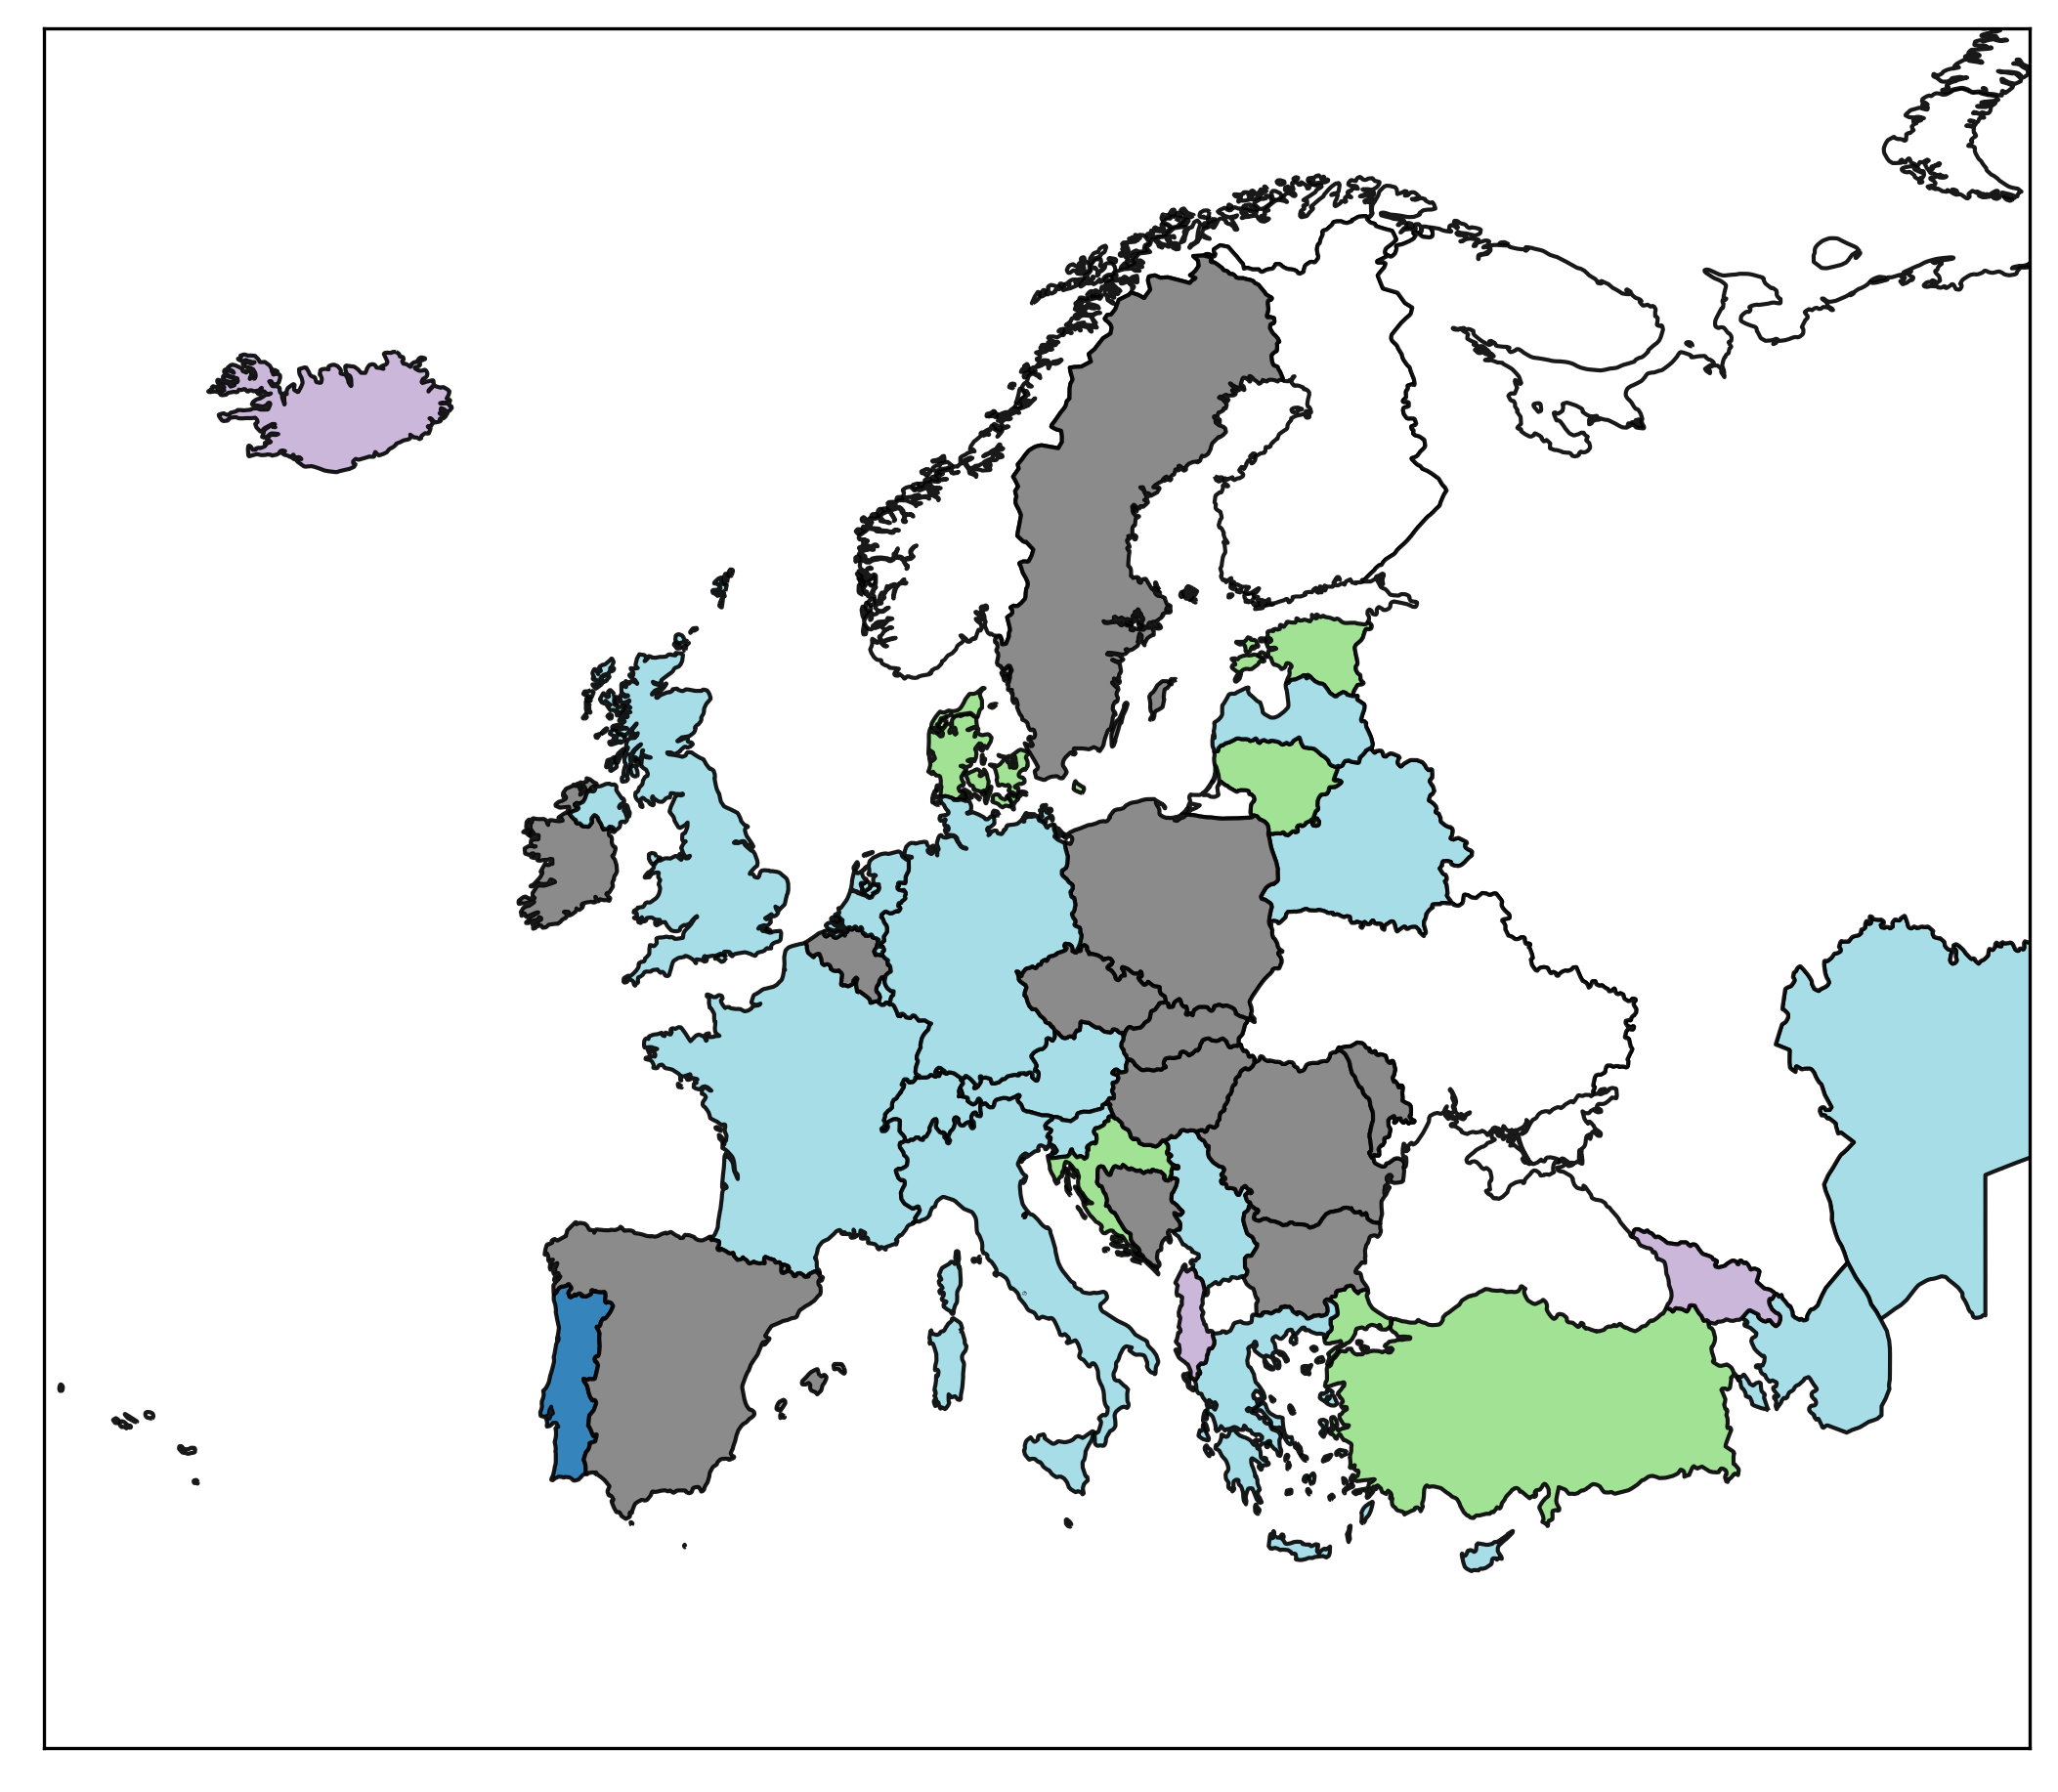

In [175]:
val_col = np.zeros(len(country_map)) - 1
for c in unique_clusters:
    for i in C[c]:
        location = wpool.key_list[i][:-2]
        c_loc = country_map.loc[country_map['iso_3166_1_'] == location]
        ind = c_loc.index[0]
        val_col[ind] = c


#fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (14,8))
#ne_county_map['val'] = val_col        
#ne_county_map.plot(column='val',legend=True, ax = ax, edgecolor = 'black', cmap = custom_cmap, alpha = 0.9)

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (16,6), dpi = 300)
country_map['val'] = val_col
country_map['color'] = country_map['val'].map(color_dict)
country_map.plot(color=country_map['color'].to_list() ,legend=False, ax = ax, edgecolor = 'black', alpha = 0.9)
ax.set_xlim(-32,58)
ax.set_ylim(30,75)
plt.xticks([])
plt.yticks([]) 

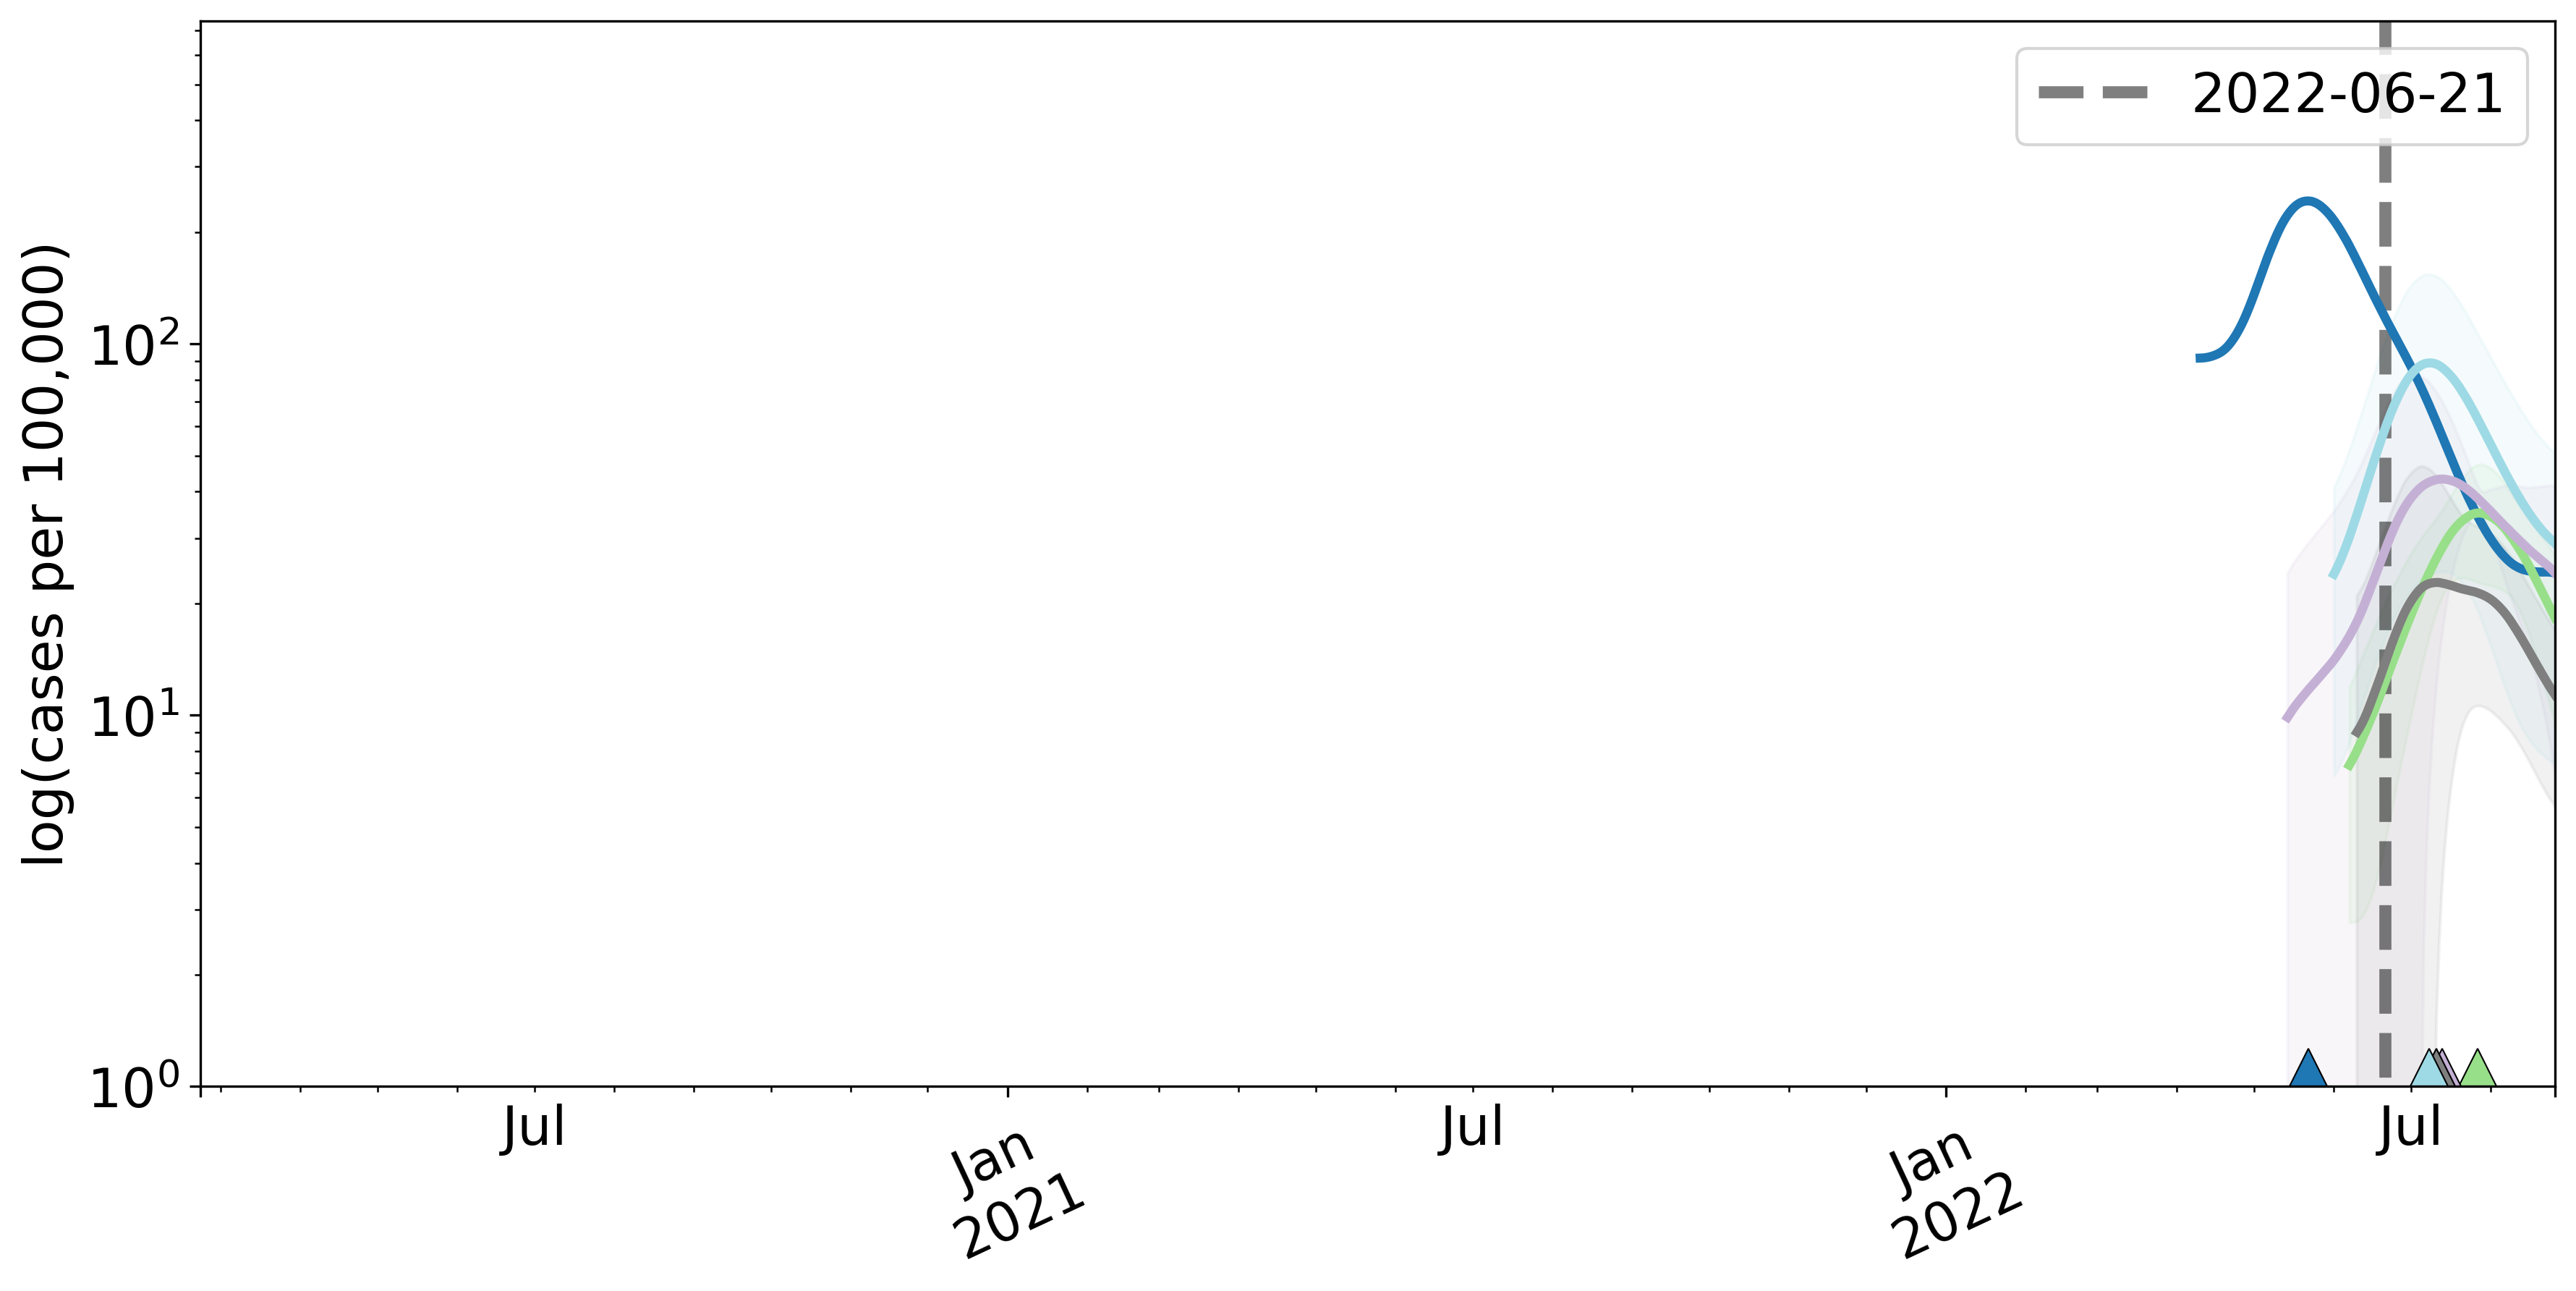

In [176]:
fig,ax = plt.subplots(figsize = (14,6.5), dpi = 300)
plt.rcParams.update({'font.size': 18})
data_max = 0
for u in unique_clusters:
    #if len(cliquer.C[u]) > 1:
    wvs = cluster_waves[u]
    cluster_color = color_dict[u]
    #cluster_color = color_dict[u]
    x = wvs.index
    mean = wvs.mean(axis = 1)
    std = wvs.std(axis = 1)

    #ax.plot(x, mean, c=cluster_color, linewidth = 2)
    #ax.fill_between(x, mean - std, mean + std, color=cluster_color, alpha=0.1)
    
    mean.plot(c = cluster_color, linewidth = 3, label='_no_legend_')
    ax.fill_between(x, mean - std, mean + std, color=cluster_color, alpha=0.1)
    
    max_idx = np.argmax(mean)
    ax.plot(x[max_idx], 1, marker='^', markersize=25, c=cluster_color, markeredgewidth=0.5, markeredgecolor='black')

    
    umax = (mean + std).max()
    if umax > data_max:
        data_max = umax

data_max = data.max().max()
ax.vlines(x = data.index[time], ymin = 0, ymax = data_max, linestyle = '--', color = 'k', linewidth = 4, label = str(data.index[time])[:10], alpha = 0.5)
ax.set_xlabel('')
ax.set_ylabel('log(cases per 100,000)')
ax.set_yscale('log', base=10)
ax.set_ylim(1, data_max)
plt.xticks(rotation=25) 
plt.legend()

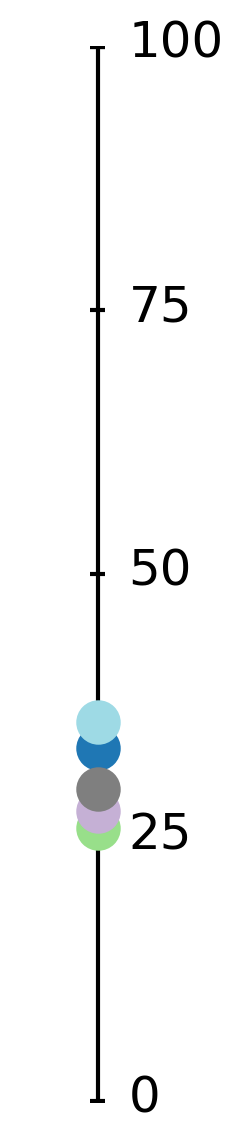

In [177]:
# set up the figure
fig = plt.figure(figsize = (1,7), dpi = 200)
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 18})

# draw lines
ymin = 0
ymax = 100
ax.set_ylim(ymin-0.1,ymax+0.1)

x = 5
height = 1
ax.set_xlim(0,10)

plt.vlines(x, ymin, xmax, color = 'k')
plt.hlines(ymin, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax//4, x - height / 2., x + height / 2., color = 'k')
plt.hlines(ymax//2, x - height/2, x + height/2, color = 'k')
plt.hlines(3*ymax//4, x - height / 2, x + height / 2, color = 'k')

# draw a point on the line
px = 4
for u in unique_clusters:
    health_val = cluster_data.loc[cluster_data.cluster == u].containment_health.values[0]
    cluster_color = color_dict[u]
    plt.plot(x, health_val, marker = 'o', ms = 15, color = cluster_color, linewidth = 10)


# add numbers
plt.text(x+2, ymin - 1, '0')#, horizontalalignment='right')
plt.text(x+2, ymax - 1, '100')#, horizontalalignment='left')
plt.text(x+2, ymax//4 - 1, '25')#, horizontalalignment='left')
plt.text(x+2, ymax//2 - 1, '50')#, horizontalalignment='left')
plt.text(x+2, 3*ymax//4 - 1, '75')#, horizontalalignment='left')

plt.axis('off')
plt.show()

## Comparison to random clusterings

In [178]:
# Non - random clusterings for baseline
# Unimodal, SIR, and wavefinder segmentation methods
uni_analysis = pd.read_csv('../../batch3/country/data/uni_analysis.csv', index_col = 0)
uni_filter = uni_analysis.loc[uni_analysis.cluster_size >= 2]

sir_analysis = pd.read_csv('../../batch3/country/data/sir_analysis.csv', index_col = 0)
sir_filter = sir_analysis.loc[sir_analysis.cluster_size >= 2]

wav_analysis = pd.read_csv('../../batch3/country/data/wav_analysis.csv', index_col = 0)
wav_filter = wav_analysis.loc[wav_analysis.cluster_size >= 2]

In [179]:
uni_filter

,cluster,cluster_size,cost,total_points,explained_variance,silhouette,geo_silhouette,health_silhouette,containment_health,avg_infections
22,22,3,0.002378,471,2.106380e+05,0.937646,0.587432,0.104605,39.474444,17.822398
23,23,2,0.002864,195,5.238808e+05,0.925783,0.343021,0.511590,47.001943,5.273325
24,24,2,0.003438,358,1.127449e+05,0.806165,0.466598,-0.376843,39.099581,4.327449
25,25,2,0.004221,513,3.557819e+06,1.000000,1.000000,1.000000,52.421142,60.394989
26,26,2,0.005574,298,3.452818e+05,1.000000,1.000000,1.000000,74.160853,30.215420
27,27,2,0.005722,202,5.979163e+05,0.862432,0.225931,0.293151,33.236571,73.528586
28,28,3,0.006654,573,4.049162e+05,0.712643,0.595265,-0.062636,67.527477,25.376597
29,29,2,0.008032,355,8.097516e+04,0.355913,0.412170,0.076897,65.705932,18.161635
30,30,5,0.009009,830,1.185529e+06,0.709562,0.185463,0.044800,49.427005,43.849331
31,31,2,0.009236,159,3.303428e+05,1.000000,1.000000,1.000000,44.652143,2.403852


In [181]:
# For comparison:

#1) random clusterings after using each of the segmentation methdods
uni_rc_analysis = pd.read_csv('../../batch3/country/data/unimodal_rc_analysis.csv', index_col = 0)
uni_rc_filter = uni_rc_analysis.loc[uni_rc_analysis.cluster_size >= 2]
#uni_rc_filter = uni_rc_filter.loc[uni_rc_filter.clustering <= 1000]

sir_rc_analysis = pd.read_csv('../../batch3/country/data/sir_rc_analysis.csv', index_col = 0)
sir_rc_filter = sir_rc_analysis.loc[sir_rc_analysis.cluster_size >= 2]
#sir_rc_filter = sir_rc_filter.loc[sir_rc_filter.clustering <= 1000]

wav_rc_analysis = pd.read_csv('../../batch3/country/data/wav_rc_analysis.csv', index_col = 0)
wav_rc_filter = wav_rc_analysis.loc[wav_rc_analysis.cluster_size >= 2]
#wav_rc_filter = wav_rc_filter.loc[wav_rc_filter.clustering <= 1000]

#2) random segmentation followed by clique clustering
#rs_analysis = pd.read_csv('../../batch3/country/data/random_segment_clusters.csv', index_col = 0)
#rs_filter = rs_analysis.loc[rs_analysis.cluster_size >= 2]

#3) random segmentation followed by random clustering
#rc_rs_analysis = pd.read_csv('../../batch3/country/data/random_segment_random_clusters.csv', index_col = 0)
#rc_rs_filter = rc_rs_analysis.loc[rc_rs_analysis.cluster_size >= 2]

In [215]:
compare = 'health_silhouette'
weight = True

In [216]:
# random clusterings
rc_clusterings = uni_rc_filter.clustering.value_counts()
uni_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in uni_rc_filter.index:
    idx = rc_dict[uni_rc_filter.loc[row, 'clustering']]
    if weight:
        uni_rc_means[idx] += uni_rc_filter.loc[row, compare]*uni_rc_filter.loc[row, 'cluster_size']
    else:
        uni_rc_means[idx] += uni_rc_filter.loc[row, compare]
    
if weight:
    uni_rc_means = uni_rc_means / len(wpool_uni.key_list)
else:
    uni_rc_means = uni_rc_means / rc_clusterings.to_numpy()

In [217]:
# random clusterings
rc_clusterings = sir_rc_filter.clustering.value_counts()
sir_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in sir_rc_filter.index:
    idx = rc_dict[sir_rc_filter.loc[row, 'clustering']]
    if weight:
        sir_rc_means[idx] += sir_rc_filter.loc[row, compare]*sir_rc_filter.loc[row, 'cluster_size']
    else:
        sir_rc_means[idx] += sir_rc_filter.loc[row, compare]
    
if weight:
    sir_rc_means = sir_rc_means / len(wpool_sir.key_list)
else:
    sir_rc_means = sir_rc_means / rc_clusterings.to_numpy()

In [218]:
# random clusterings
rc_clusterings = wav_rc_filter.clustering.value_counts()
wav_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in wav_rc_filter.index:
    idx = rc_dict[wav_rc_filter.loc[row, 'clustering']]
    if weight:
        wav_rc_means[idx] += wav_rc_filter.loc[row, compare]*wav_rc_filter.loc[row, 'cluster_size']
    else:
        wav_rc_means[idx] += wav_rc_filter.loc[row, compare]
    
if weight:
    wav_rc_means = wav_rc_means / len(wpool_wav.key_list)
else:
    wav_rc_means = wav_rc_means / rc_clusterings.to_numpy()

In [ ]:
# random segments
rs_clusterings = rs_filter['sample'].value_counts()
sizes = np.array([rs_filter.loc[rs_filter.clustering == i].cluster_size.sum() for i in rs_clusterings.index])
rs_means = np.zeros(len(rs_clusterings))
rs_dict = {rs_clusterings.index[i]:i for i in range(len(rs_clusterings))}
for row in rs_filter.index:
    idx = rs_dict[rs_filter.loc[row, 'sample']]
    if weight:
        rs_means[idx] += rs_filter.loc[row, compare]*rs_filter.loc[row, 'cluster_size']
    else:
        rs_means[idx] += rs_filter.loc[row, compare]
    
if weight:
    rs_means = rs_means / sizes
else:
    rs_means = rs_means / rs_clusterings.to_numpy()

In [ ]:
# random segments random cluster
rc_rs_clusterings = rc_rs_filter['sample'].value_counts()
sizes = np.array([rc_rs_filter.loc[rc_rs_filter.clustering == i].cluster_size.sum() for i in rc_rs_clusterings.index])
rc_rs_means = np.zeros(len(rc_rs_clusterings))
rc_rs_dict = {rc_rs_clusterings.index[i]:i for i in range(len(rc_rs_clusterings))}
for row in rc_rs_filter.index:
    idx = rc_rs_dict[rc_rs_filter.loc[row, 'sample']]
    if weight:
        rc_rs_means[idx] += rc_rs_filter.loc[row, compare]*rc_rs_filter.loc[row, 'cluster_size']
    else:
        rc_rs_means[idx] += rc_rs_filter.loc[row, compare]
    
if weight:
    rc_rs_means = rc_rs_means / sizes
else:
    rc_rs_means = rc_rs_means / rc_rs_clusterings.to_numpy()

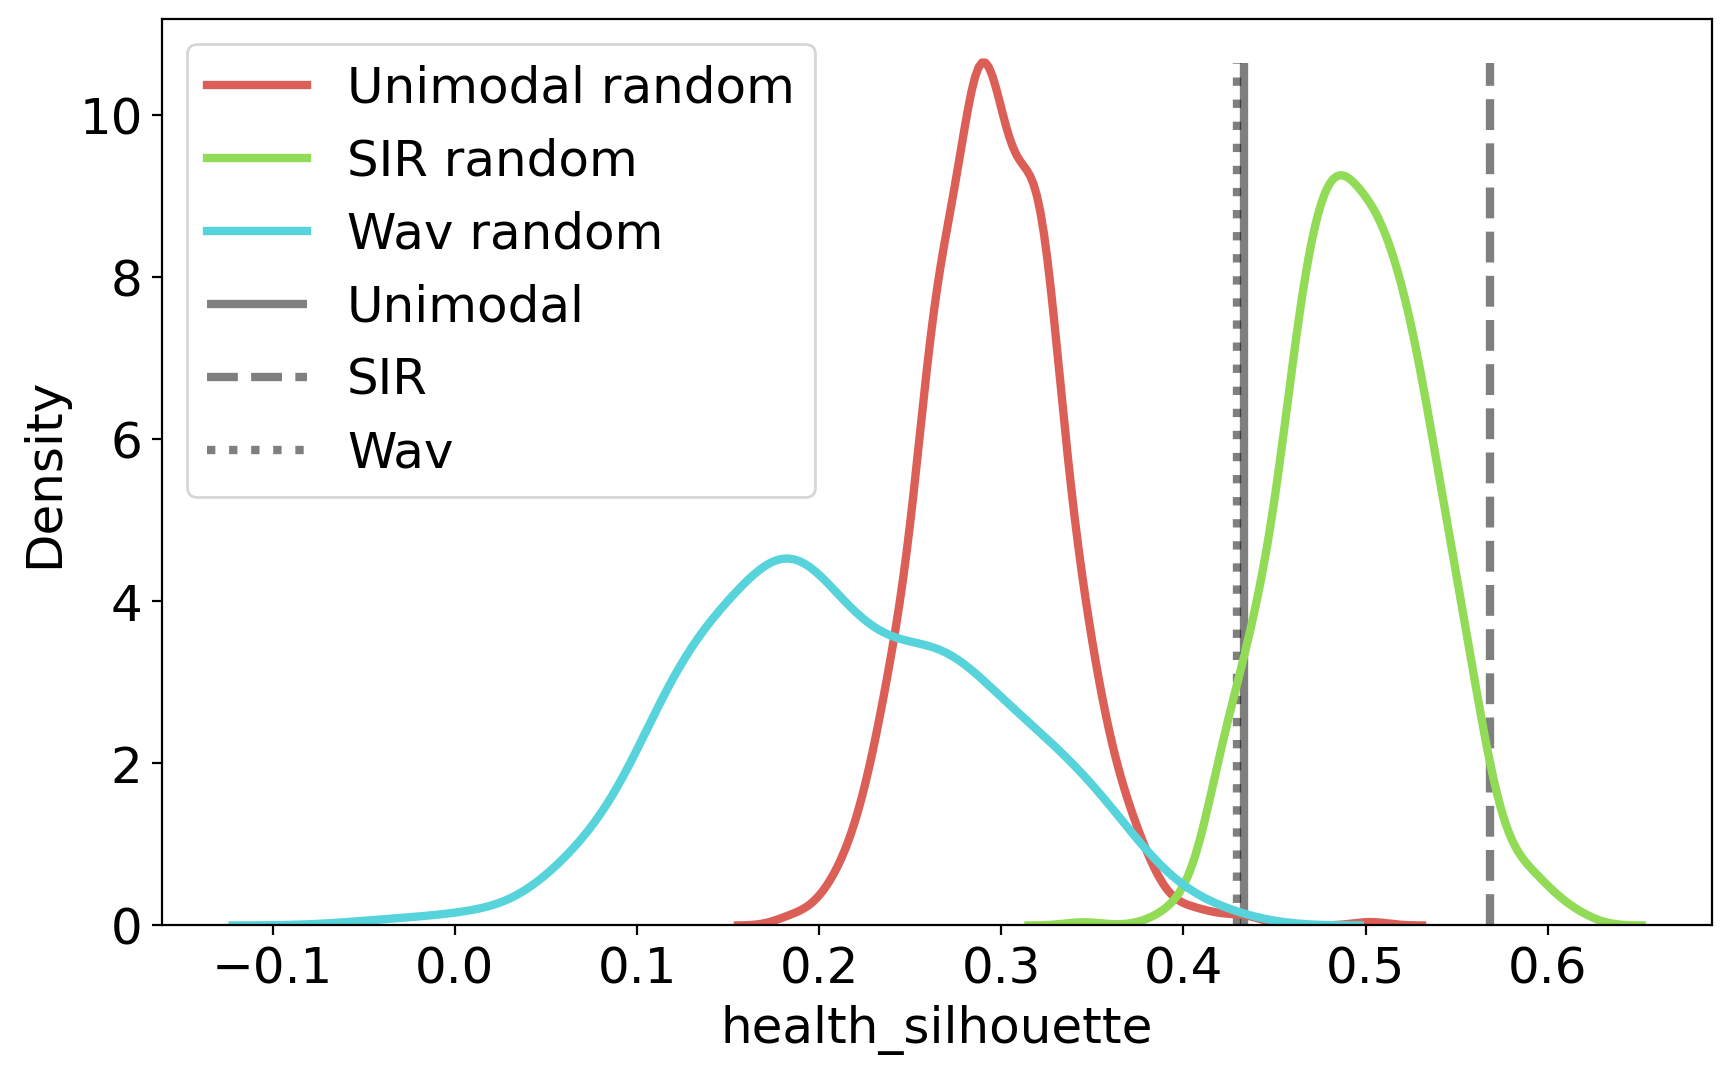

In [220]:
fig,ax = plt.subplots(figsize = (10,6), dpi = 200)
plt.rcParams.update({'font.size': 18})
pal = sns.color_palette("hls", 8)
s1 = sns.kdeplot(uni_rc_means, ax = ax, color = pal[0], label = 'Unimodal random', linewidth = 3)
s2 = sns.kdeplot(sir_rc_means, ax = ax, color = pal[2], label = 'SIR random', linewidth = 3)
s3 = sns.kdeplot(wav_rc_means, ax = ax, color = pal[4], label = 'Wav random', linewidth = 3)
#s4 = sns.kdeplot(rs_means, ax = ax, color = pal[6], label = 'random segments')
#s5 = sns.kdeplot(rc_rs_means, ax = ax, color = pal[7], label = 'random both', linewidth = 3)

_,y = ax.lines[0].get_data()
max_height = np.max(y)

if weight:
    uni_avg = np.sum((uni_filter.loc[:,compare] * uni_filter.loc[:, 'cluster_size'])) / len(wpool_uni.key_list)
    sir_avg = np.sum((sir_filter.loc[:,compare] * sir_filter.loc[:, 'cluster_size'])) / len(wpool_sir.key_list)
    wav_avg = np.sum((wav_filter.loc[:,compare] * wav_filter.loc[:, 'cluster_size'])) / len(wpool_wav.key_list)
else:
    uni_avg = uni_filter.loc[:,compare].mean()
    sir_avg = sir_filter.loc[:,compare].mean()
    wav_avg = wav_filter.loc[:,compare].mean()
    
ax.vlines(x = uni_avg, ymin = 0, ymax = max_height, linestyle = 'solid', color = 'k', 
          linewidth = 3, label = 'Unimodal', alpha = 0.5)


ax.vlines(x = sir_avg, ymin = 0, ymax = max_height, linestyle = '--', color = 'k', 
          linewidth = 3, label = 'SIR', alpha = 0.5)


ax.vlines(x = wav_avg, ymin = 0, ymax = max_height, linestyle = 'dotted', color = 'k', 
          linewidth = 3, label = 'Wav', alpha = 0.5)

ax.set_xlabel(compare)


plt.legend(fontsize = 18)